# UNSTRUCTURED DATA - ASSIGNMENT 2

Theresa Sushil (ts42924)

Aman Sharma (as235548)

Navya Singhal (ns38323)

Sushanth Ravichandran (sr56925)

Anjali Pillai (ap66745)

Sarthak Shivnani (ss223347)

# **TASK A**

### Webscraping

In [ ]:
pip install selenium
pip install webdriver_manager

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support import expected_conditions as EC
import time
import csv
import pandas as pd

In [ ]:
# Set up Edge WebDriver
driver = webdriver.Edge(service=Service(EdgeChromiumDriverManager().install()))

# Open the top beers page
driver.get('https://www.ratebeer.com/top-beers')

# Allow the page to load
time.sleep(3)

# Find all the beer entries on the page
beer_elements = driver.find_elements(By.CSS_SELECTOR, 'a.CompactList___StyledLink-dcQTlx')

# Collect beer names and links
beers = []
all_reviews_and_ratings = []
for beer in beer_elements:
    beer_name = beer.text  # Get the text of the beer (beer name)
    beer_link = beer.get_attribute('href')  # Get the link associated with the beer
    beers.append((beer_name, beer_link))

# Select top 4, middle 3 (27-30), and last 3 ranked beers
selected_beers = beers
# beers[:4] + beers[26:30] + beers[-3:]

# Create CSV file to store the reviews
csv_filename = "beer_reviews_ratings.csv"

# Function to scrape reviews from a beer page
def scrape_reviews(beer_name, beer_link):
    driver.get(beer_link)
    time.sleep(3)  # Allow the page to load

    review_count = 0  # Counter to keep track of the number of reviews scraped
    reviews_and_ratings = []

    # Close any cookie pop-up that appears on the first page
    try:
        close_button = driver.find_element(By.XPATH, "//button[@class='onetrust-close-btn-handler onetrust-close-btn-ui banner-close-button ot-close-icon']")
        close_button.click()
        time.sleep(1)  # Allow the click to register
    except NoSuchElementException:
        pass  # If the button is not there, move on

    # Keep scraping until there are no more pages or the review count reaches 200
    while review_count < 61:
        try:
            # Find the beer title using XPath to locate the div with the specific class
            beer_name = driver.find_element(By.XPATH, "//div[contains(@class, 'MuiTypography-h4') and contains(@class, 'mt-3')]").text
            review_elements = driver.find_elements(By.CSS_SELECTOR, '.MuiTypography-root.Text___StyledTypographyTypeless-bukSfn.pzIrn.colorized__WrappedComponent-hrwcZr.hwjOn.BeerReviewListItem___StyledText-kMbsdb.gCtEHi.pre-wrap.MuiTypography-body1 .LinesEllipsis')
            rating_elements = driver.find_elements(By.CSS_SELECTOR, '.MuiTypography-root.Text___StyledTypographyTypeless-bukSfn.pzIrn.text-500.colorized__WrappedComponent-hrwcZr.bRPQdN.MuiTypography-subtitle1')

            i=1
            # Pair each review with the corresponding rating
            for review, rating in zip(review_elements, rating_elements):
                if review_count >= 61:
                    break

                # XPath for the comment without 'Show More'
                review_comment_xpath_no_show = f'//*[@id="root"]/div[2]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/div[3]/div[{i}]/div/section[2]/div[1]/div/div[1]/div'
                # XPath for the comment with 'Show More'
                comment_show_more_xpath = f'//*[@id="root"]/div[2]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/div[3]/div[{i}]/div/section[2]/div[1]/div/div[1]'
                # XPath for 'Show More' button
                show_more_xpath = f'//*[@id="root"]/div[2]/div[2]/div/div/div/div[2]/div[1]/div[2]/div/div[3]/div[{i}]/div/section[2]/div[1]/div/button/span[1]'

                try:
                    show_more_button = review.find_element(By.XPATH, show_more_xpath)
                    if show_more_button:
                        show_more_button.click()  # Click the "Show more" button to expand the review
                        time.sleep(2)  # Allow the full review to be displayed
                        comment_xpath = comment_show_more_xpath
                    else:
                        comment_xpath = review_comment_xpath_no_show
                except NoSuchElementException:
                    comment_xpath = review_comment_xpath_no_show
                    print(f"No 'Show more' button found for comment")  # If the "Show more" button isn't there, move on

                comment_element = WebDriverWait(driver, 5).until(
                    EC.visibility_of_element_located((By.XPATH, comment_xpath))
                )

                full_review_text = comment_element.text

                reviews_and_ratings.append({
                    "name": beer_name,
                    "review": full_review_text,
                    "rating": rating.text
                })
                review_count += 1
                i+=1

            # Check if the "Next page" button is available and interactable
            next_button = driver.find_element(By.XPATH, "//button[@aria-label='Next page']")

            # Check if the button is disabled (i.e., we have reached the last page)
            if next_button.get_attribute("disabled"):
                break

            # Scroll to the "Next page" button and click it
            actions = ActionChains(driver)
            actions.move_to_element(next_button).perform()
            next_button.click()
            time.sleep(3)  # Allow time for the next page to load

        except NoSuchElementException:
            print("No 'Next page' button found or no more pages available.")
            break
        except ElementClickInterceptedException:
            print("Element click was intercepted. Attempting to retry.")
            time.sleep(2)  # Give time for any pop-ups to disappear
            continue

    return reviews_and_ratings

# Scrape reviews for selected beers
for beer_name, beer_link in selected_beers:
    print(f"Scraping reviews for {beer_name}...")
    reviews_and_ratings = scrape_reviews(beer_name, beer_link)
    all_reviews_and_ratings.extend(reviews_and_ratings)

# Write reviews and ratings to the CSV file
with open(csv_filename, 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=["Name", "Review", "Rating"])
    writer.writeheader()  # CSV header
    for data in all_reviews_and_ratings:
        writer.writerow({"Name": data["name"], "Review": data["review"], "Rating": data["rating"]})

# Close the browser
driver.quit()

print(f"Scraping completed. Reviews saved in {csv_filename}.")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving beer_reviews_ratings.csv to beer_reviews_ratings.csv


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter

# Load the CSV data
df = pd.read_csv("beer_reviews_ratings.csv")

df.head()

,Name,Review,Rating
0,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3
1,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5
2,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3
3,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7
4,Toppling Goliath Kentucky Brunch,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",4.9


## Analyzing the posts
Upon eyeballing it seemed that some of the posts are in different languages. Let's investigate further

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/981.5 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 553.0/981.5 kB 16.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=131a56393a1cb49ba5fcaf4bc10c7466a75cdbbfabea37eb3472a3b9af6004b6
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import pandas as pd
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException


# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"  # Handles cases of gibberish or empty strings

# Apply language detection to the "Review" column
df['language'] = df['Review'].apply(detect_language)

# Count occurrences of different languages
language_counts = df['language'].value_counts()

# Output counts for each detected language
print("Language counts:\n", language_counts)

# Filter and output the reviews in different languages
non_english_reviews = df[df['language'] != 'en']

# Show the first few reviews in non-English languages as a sample
print("\nNon-English reviews:\n", non_english_reviews[['Review', 'language']].head())

Language counts:
 language
en    2553
pl     119
nl      38
sv      30
fr      22
it      15
de      12
es      10
da       7
ru       6
no       4
hu       3
af       2
ca       2
cs       1
id       1
sk       1
fi       1
pt       1
Name: count, dtype: int64

Non-English reviews:
                                                Review language
14  Amai, het ganse plaatje klopte, balans, diepga...       nl
15  Flaska från TG, 2020. Svart med bruna/rubinröd...       sv
18  En fin øl med en god smag af malt og man aner ...       da
30  Colore nero con bella testa marrone. Aroma mal...       it
31  Versato da una bottiglia. Cioccolato, vaniglia...       it


### As we can see from above, 10% of the reviews are not in English which have been translated

In [ ]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=e493d411fda4d0cee128c7f6b0c3e57cf79ecb85ea259f4eaae79e56c47c4523
  Stored in directory: /Users/amansharma/Library/Caches/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninst

In [ ]:

from langdetect.lang_detect_exception import LangDetectException
from googletrans import Translator


# Initialize translator object
translator = Translator()

# Function to translate text
def translate_to_english(text, lang):
    if lang == 'en' or lang == 'unknown':
        return text  # No need to translate English or gibberish
    try:
        translated = translator.translate(text, src=lang, dest='en')
        return translated.text
    except Exception as e:
        return f"Error in translation: {e}"


# Translate non-English reviews
df['translated_review'] = df.apply(lambda row: translate_to_english(row['Review'], row['language']), axis=1)

# Show original and translated version of some non-English reviews
non_english_reviews = df[df['language'] != 'en'][['Review', 'translated_review', 'language']].head(3)

# Print a few original and translated reviews
print("Original and Translated Reviews:\n")
for index, row in non_english_reviews.iterrows():
    print(f"Original Review (Language: {row['language']}): {row['Review']}")
    print(f"Translated Review: {row['translated_review']}\n")

Original and Translated Reviews:

Original Review (Language: nl): Amai, het ganse plaatje klopte, balans, diepgang, power, intens maar niks wat er op een negatieve manier boven uit stak! een kanjer
Translated Review: Amai, the whole picture beat, balance, depth, power, intense but nothing that stuck out in a negative way!a hunk

Original Review (Language: sv): Flaska från TG, 2020. Svart med bruna/rubinröda toner i kanten, brun liten skumkrona med fina bubblor i kanterna. Doftar av kaffe, lönnsirap, choklad, vanilj, choklad- och vaniljwafers, lätt whiskeyton. Även en angenäm lite bärig ton som drar åt inlagda körsbär som jag helt saknar i MD:n. Mycket samma i smaken som i doften. Snygg och mjuk kaffeton, mocca, lönnsirap, choklad, hasselnöt, nötkräm. Ruskigt fint integrerad fatkaraktär, men egentligen inte jättemycket smak från whiskeyn. Väldigt snäll eldighet på sin höjd. Väl avvägt, elegant trots kraftpaket. Görs helt klart öl som är större och maffigare, men här balanseras det med e

In [ ]:
df.to_csv('translated_beer_reviews.csv')

In [ ]:
df = pd.read_csv('translated_beer_reviews.csv')
df.head()

,Unnamed: 0,Name,Review,Rating,language,translated_review
0,0,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,en,"You need personal informations from companies,..."
1,1,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,en,"Bottle after MBCC 2024. Black colour, malty ar..."
2,2,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,en,Thank you for sharing this Chris - Black with ...
3,3,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,en,"Boxed beer at home, proper glassware. Pitch bl..."
4,4,Toppling Goliath Kentucky Brunch,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",4.9,en,"From backlog. (As 2018 Vintage) 0,3 litre Bott..."


In [ ]:
import matplotlib.pyplot as plt
def length(s):
  return len(str(s))
df['Review_len'] = df['translated_review'].map(length)
print(df['Review_len'].mean())
print(df['Review_len'].median())
print(df['Review_len'].min())



364.1676096181047
273.0
69


#### None of the reviews seem to have too few character to be gibberish

In [ ]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 20.3 MB/s eta 0:00:00a 0:00:01


In [ ]:
import pandas as pd
from spellchecker import SpellChecker
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Ensure nltk's word_tokenize resources are available
nltk.download('punkt', quiet=True)

# Initialize the spell checker
spell = SpellChecker()

# Function to check misspelled words and suggest corrections
def spell_check(review):
    # Tokenize the review into words
    words = word_tokenize(review.lower())

    # Find misspelled words
    misspelled = spell.unknown(words)

    # Create a dictionary of misspelled words and their corrections
    corrections = {word: spell.correction(word) for word in misspelled}

    return corrections

# Take a 10% sample of the dataset
df_sample = df.sample(frac=0.01, random_state=42)

# Apply spell checking with progress tracking on the 10% sample
tqdm.pandas()
df_sample['spell_errors'] = df_sample['translated_review'].progress_apply(spell_check)

# Check for reviews with spelling errors in the sample
misspelled_reviews_sample = df_sample[df_sample['spell_errors'].apply(lambda x: len(x) > 0)]

# Output the first few rows of reviews with spelling errors from the sample
print(misspelled_reviews_sample[['translated_review', 'spell_errors']].head())

# Count total number of misspelled words in the sample
total_misspelled_words_sample = misspelled_reviews_sample['spell_errors'].apply(len).sum()

print(f"Total misspelled words in the 1% sample: {total_misspelled_words_sample}")

100%|███████████████████████████████████████████| 28/28 [00:12<00:00,  2.33it/s]

                                      translated_review  \
1506  Bottle thanks to Aron. Pours lack with almost ...   
817   I have been lucky to have had this beer 5 year...   
411   Bottle at Dougs, thanks man \n\nPours black wi...   
331   On tap at CC for the Huanhpu’s release.  Vibra...   
2530  Bottle shared @ Akkurat. Pours lightly hazy go...   

                                           spell_errors  
1506                                   {'aron': 'iron'}  
817   {'🍻': 'i', 'yeara': 'years', 'pliny': 'liny', ...  
411                                  {'dougs': 'drugs'}  
331   {'huanhpu': None, '.....': None, 'berry/fruit'...  
2530  {'oaky': 'okay', 'akkurat': None, 'citrussy': ...  
Total misspelled words in the 1% sample: 93


### We observed typos and ran a spellcheck analysis as seen above. However, there were quite a few false positives, the checker is translating colloquial words like doug to drugs; proper nouns like Aron to iron

In [ ]:
df= df[['Name', 'translated_review','Rating']]
df.columns = ['Name','Review','Rating']

## Pre-processing

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from multiprocessing import Pool

# Ensure NLTK resources are downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get the WordNet POS tag for accurate lemmatization
def get_wordnet_pos(word):
    from nltk.corpus.reader.wordnet import NOUN, VERB, ADJ, ADV
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"N": NOUN, "V": VERB, "J": ADJ, "R": ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocessing function with tokenization and lemmatization (no spell check or n-grams)
def preprocess_review(review):
    if isinstance(review, str):
        # Convert to lowercase and remove punctuation
        review = review.lower().translate(str.maketrans('', '', string.punctuation))

        # Tokenize and remove stopwords
        tokens = [word for word in word_tokenize(review) if word not in stopwords.words('english')]

        # Lemmatize tokens based on POS tags
        tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

        return tokens
    return []

# Parallelize the preprocessing across multiple processors for speed
def parallelize_preprocessing(df, num_partitions=4):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_partitions)
    df = pd.concat(pool.map(apply_preprocessing, df_split))
    pool.close()
    pool.join()
    return df

# Function to apply preprocessing in parallel
def apply_preprocessing(df):
    df['processed_review'] = df['Review'].apply(preprocess_review)
    return df

# Assuming you have a DataFrame 'df' with a 'Review' column
# Apply preprocessing to all reviews using parallelization
df = parallelize_preprocessing(df)

# Save the processed data
df.to_csv('processed_sample_beer_reviews.csv', index=False)

# Display the first few rows
df.head()

# **TASK B**

### Word Frequency

In [146]:
from google.colab import files
uploaded = files.upload()

Saving processed_sample_beer_reviews.csv to processed_sample_beer_reviews (1).csv


In [147]:
df = pd.read_csv('processed_sample_beer_reviews.csv')

In [148]:
df.head()

,Name,Review,Rating,processed_review
0,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"['need', 'personal', 'information', 'companies..."
1,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"['bottle', 'mbcc', '2024', 'black', 'colour', ..."
2,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"['thank', 'share', 'chris', 'black', 'brown', ..."
3,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"['boxed', 'beer', 'home', 'proper', 'glassware..."
4,Toppling Goliath Kentucky Brunch,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",4.9,"['backlog', '2018', 'vintage', '03', 'litre', ..."


In [149]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
# Tokenize each review into words
all_words = [word for review in df['Review'] for word in word_tokenize(review.lower())]
# Filter out stopwords and non-alphabetic tokens
stopwords_set = set(stopwords.words('english'))  # Convert stopwords list to a set for faster lookups
filtered_words = [word for word in all_words if word.isalpha() and word not in stopwords_set]
# Count the frequency of each unigram (word)
word_freq = Counter(filtered_words)
# Get the top 1000 most common unigrams
top_1000_words = word_freq.most_common(1000)
# Convert the list of tuples (word, frequency) into a DataFrame for easier manipulation
top_1000_df = pd.DataFrame(top_1000_words, columns=['word', 'frequency'])
# Export the top 1000 most common unigrams to a CSV file
top_1000_df.to_csv('top_1000_unigrams.csv', index=False)
print("Top 1000 unigrams have been saved to 'top_1000_unigrams.csv'.")

Top 1000 unigrams have been saved to 'top_1000_unigrams.csv'.


In [150]:
top_1000_df[:20]

,word,frequency
0,sweet,1703
1,dark,1647
2,chocolate,1613
3,head,1569
4,aroma,1527
5,bottle,1503
6,vanilla,1345
7,taste,1254
8,black,1144
9,beer,998


### TF IDF

In [151]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert processed reviews back to strings for TF-IDF calculation (unigrams only)
df['processed_review_str'] = df['Review'].apply(lambda tokens: ' '.join(tokens))

# Initialize TfidfVectorizer to include only unigrams
tfidf = TfidfVectorizer(stop_words='english')  # Include only 1-grams (unigrams)

# Fit and transform the processed reviews
tfidf_matrix = tfidf.fit_transform(df['Review'])

# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

# Get the IDF values
idf_values = tfidf.idf_

# Extract the term frequency (TF) matrix and sum across all documents
tf_matrix = tfidf_matrix.sum(axis=0).A1

# Compute the TF-IDF values by multiplying the term frequencies by the IDF values
tfidf_scores = tf_matrix * idf_values

# Create a DataFrame with words, TF, IDF, and TF-IDF
tfidf_df = pd.DataFrame({
    'word': feature_names,
    'tf': tf_matrix,
    'idf': idf_values,
    'tfidf': tfidf_scores
})

# Sort the DataFrame by the TF-IDF scores in descending order
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)

# Select the top 1000 words (unigrams)
top_1000_df_tf = tfidf_df.head(1000)

# Export to CSV
top_1000_df_tf.to_csv('top_1000_tf_idf_unigrams.csv', index=False)

print("Top 1000 unigrams have been saved to 'top_1000_tf_idf_unigrams.csv'.")

Top 1000 unigrams have been saved to 'top_1000_tf_idf_unigrams.csv'.


In [152]:
top_1000_df_tf[:20]

,word,tf,idf,tfidf
1789,chocolate,120.601897,1.991133,240.134432
1928,coffee,92.612838,2.542450,235.463520
1286,bourbon,88.084521,2.589836,228.124490
8357,vanilla,106.714423,2.108202,224.975574
2349,dark,113.835564,1.957422,222.824246
7728,sweet,116.446461,1.847651,215.152466
3974,honey,78.413459,2.721142,213.374148
4712,light,78.070638,2.473788,193.130197
998,beer,76.620812,2.410987,184.731779
5515,notes,72.021322,2.521190,181.579445


### Most Common Attributes (and their Lift Values)

In [153]:
top_1000_df[:20]

,word,frequency
0,sweet,1703
1,dark,1647
2,chocolate,1613
3,head,1569
4,aroma,1527
5,bottle,1503
6,vanilla,1345
7,taste,1254
8,black,1144
9,beer,998


Top 5 co-occurring attribute pairs:
Pair: coffee - bourbon, Lift: 0.0007
Pair: vanilla - bourbon, Lift: 0.0007
Pair: chocolate - coffee, Lift: 0.0007
Pair: light - notes, Lift: 0.0007
Pair: chocolate - bourbon, Lift: 0.0006


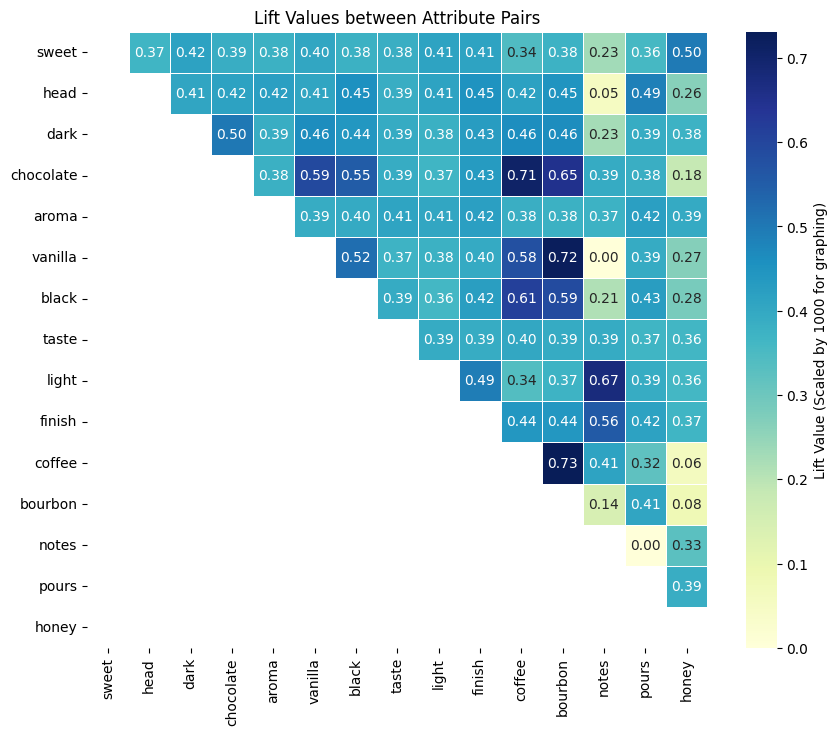

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the attributes you want to analyze
attributes = ['sweet', 'head', 'dark', 'chocolate', 'aroma', 'vanilla', 'black', 'taste', 'light', 'finish', 'coffee', 'bourbon', 'notes', 'pours','honey']

# Function to calculate co-occurrence counts
def cooccurrence_count(review, attributes):
    count = sum([1 for attr in attributes if attr in review])
    return count == len(attributes)

# Create a new column for co-occurrence of attributes
df['cooccurrence'] = df['processed_review'].apply(lambda x: cooccurrence_count(x, attributes))

# Initialize a DataFrame to store the lift values and a list to store pairs with their lift
lift_matrix = pd.DataFrame(index=attributes, columns=attributes)
lift_values = []
seen_pairs = set()  # To track seen attribute pairs

# Calculate lift values and populate the matrix
for attr1 in attributes:
    for attr2 in attributes:
        if attr1 != attr2 and (attr1, attr2) not in seen_pairs and (attr2, attr1) not in seen_pairs:
            # Calculate co-occurrence counts
            both_count = df[df['processed_review'].apply(lambda x: attr1 in x and attr2 in x)].shape[0]
            attr1_count = df[df['processed_review'].apply(lambda x: attr1 in x)].shape[0]
            attr2_count = df[df['processed_review'].apply(lambda x: attr2 in x)].shape[0]
            # Calculate lift (accounting for division by zero)
            lift = both_count / (attr1_count * attr2_count) if attr1_count * attr2_count > 0 else 0
            lift_matrix.at[attr1, attr2] = lift
            lift_values.append((attr1, attr2, lift))  # Store the pair and its lift value
            seen_pairs.add((attr1, attr2))  # Mark the pair as seen
        else:
            lift_matrix.at[attr1, attr2] = np.nan  # Keep the diagonal and duplicate pairs as NaN

# Convert values to numeric for proper plotting
lift_matrix = lift_matrix.apply(pd.to_numeric) * 1000

# Sort the lift values in descending order and select the top 5 unique pairs
sorted_lift_values = sorted(lift_values, key=lambda x: x[2], reverse=True)
top_5_pairs = sorted_lift_values[:5]

# Display the top 5 co-occurring attribute pairs
print("Top 5 co-occurring attribute pairs:")
for pair in top_5_pairs:
    print(f"Pair: {pair[0]} - {pair[1]}, Lift: {pair[2]:.4f}")

# Plot the lift matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(lift_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Lift Value (Scaled by 1000 for graphing)'})
plt.title("Lift Values between Attribute Pairs")
plt.show()

### From the lift analysis above the 3 attributes we have picked are vanilla, coffee and bourbon

# **TASK C**

### Similarity Scores using BOW

In [155]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Define the function to calculate similarity using Bag of Words
def calculate_similarity(attributes, df, review_column, beer_name_column, output_csv):
    """
    This function takes in a list of attributes, a dataframe containing reviews and beer names,
    and computes the cosine similarity between the bag-of-words vector of the attributes and each review.

    Args:
    attributes: List of attribute words to compare against.
    df: DataFrame containing the reviews.
    review_column: Column in the dataframe that contains the processed reviews.
    beer_name_column: Column that contains the beer names.
    output_csv: Path to the CSV file where the results will be saved.

    Output:
    A CSV file with beer_name, review, and similarity columns.
    """
    # Convert the attribute list into a single string
    attribute_string = ' '.join(attributes)

    # Convert processed reviews (which are in tokenized form) back to strings
    df['processed_review_str'] = df[review_column].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)

    # Combine the attribute string with the processed reviews
    all_documents = df['processed_review_str'].tolist() + [attribute_string]

    # Initialize CountVectorizer (Bag of Words model)
    vectorizer = TfidfVectorizer()

    # Fit and transform the documents into Bag of Words vectors
    bow_matrix = vectorizer.fit_transform(all_documents)

    # Compute the cosine similarity between the reviews and the attribute vector
    cosine_similarities = cosine_similarity(bow_matrix[:-1], bow_matrix[-1]).flatten()

    # Add the cosine similarity values to the DataFrame in a single column
    df['similarity_bag_of_words'] = cosine_similarities

    # Select relevant columns for output
    result_df = df[[beer_name_column, 'processed_review_str', 'similarity_bag_of_words']]

    # Save the result to a CSV file
    result_df.to_csv(output_csv, index=False)

    print(f"CSV file has been saved as {output_csv}.")

# Example usage
# Assuming the reviews are stored in 'processed_review' column and beer names in 'Name'
attributes = ['coffee', 'bourbon', 'vanilla']  # Example attributes to test
calculate_similarity(attributes, df, 'processed_review', 'Name', 'beer_similarity_bag_of_words_results.csv')

df.head()

CSV file has been saved as beer_similarity_bag_of_words_results.csv.


,Name,Review,Rating,processed_review,processed_review_str,cooccurrence,similarity_bag_of_words
0,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"['need', 'personal', 'information', 'companies...","['need', 'personal', 'information', 'companies...",False,0.000000
1,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"['bottle', 'mbcc', '2024', 'black', 'colour', ...","['bottle', 'mbcc', '2024', 'black', 'colour', ...",False,0.108173
2,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"['thank', 'share', 'chris', 'black', 'brown', ...","['thank', 'share', 'chris', 'black', 'brown', ...",False,0.124170
3,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"['boxed', 'beer', 'home', 'proper', 'glassware...","['boxed', 'beer', 'home', 'proper', 'glassware...",False,0.205312
4,Toppling Goliath Kentucky Brunch,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",4.9,"['backlog', '2018', 'vintage', '03', 'litre', ...","['backlog', '2018', 'vintage', '03', 'litre', ...",False,0.158786


### To prevent bias towards longer reviews in the bag of words model we have normalized the vector

### Similarity Scores using Word Vectors

In [ ]:
pip install spacy

In [156]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [157]:
import spacy
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load spaCy model with medium-sized pretrained vectors
nlp = spacy.load("en_core_web_md")

def compute_similarity(attribute_text, review_text):
    """
    Compute the cosine similarity between the customer attributes and the beer review.
    """
    # Convert the attributes and review text into word vectors using spaCy
    attr_vector = nlp(attribute_text).vector.reshape(1, -1)
    review_vector = nlp(review_text).vector.reshape(1, -1)

    # Handle cases where reviews are too short or empty, resulting in zero vectors
    if attr_vector.sum() == 0 or review_vector.sum() == 0:
        return 0.0

    # Calculate cosine similarity between the two vectors
    similarity = cosine_similarity(attr_vector, review_vector)[0][0]

    return similarity

def calculate_similarity(df, customer_attributes, review_column, beer_name_column):
    """
    Calculate similarity between customer attributes and each beer review in the DataFrame.

    Args:
    df: DataFrame containing beer reviews.
    customer_attributes: List of attributes provided by the customer.
    review_column: Column name of the processed reviews in the dataframe.
    beer_name_column: Column name for the beer names in the dataframe.
    """
    # Preprocess the attributes into a single string
    customer_attributes = " ".join(customer_attributes.split(", "))

    # Loop over each row in the beer reviews file and calculate similarity
    similarity_scores = []
    for index, row in df.iterrows():
        processed_review = row[review_column]

        # If processed_review is a list of tokens, join them into a string
        if isinstance(processed_review, list):
            processed_review = " ".join(processed_review)

        # Compute similarity between the customer attributes and the review
        similarity_score = compute_similarity(customer_attributes, processed_review)
        similarity_scores.append(similarity_score)

    # Store the similarity scores in a new column in the DataFrame
    df['similarity_word_vectors'] = similarity_scores

    print("Similarity scores based on word vectors have been added to the DataFrame.")

# Example usage:
customer_attributes = "coffee, vanilla, bourbon"  # Example attributes from the customer
calculate_similarity(df, customer_attributes, 'processed_review', 'Name')
df.to_csv('beer_similarity_with_word_vectors.csv', index=False)

Similarity scores based on word vectors have been added to the DataFrame.


In [158]:
df.head()

,Name,Review,Rating,processed_review,processed_review_str,cooccurrence,similarity_bag_of_words,similarity_word_vectors
0,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"['need', 'personal', 'information', 'companies...","['need', 'personal', 'information', 'companies...",False,0.000000,0.021402
1,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"['bottle', 'mbcc', '2024', 'black', 'colour', ...","['bottle', 'mbcc', '2024', 'black', 'colour', ...",False,0.108173,0.076517
2,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"['thank', 'share', 'chris', 'black', 'brown', ...","['thank', 'share', 'chris', 'black', 'brown', ...",False,0.124170,0.083926
3,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"['boxed', 'beer', 'home', 'proper', 'glassware...","['boxed', 'beer', 'home', 'proper', 'glassware...",False,0.205312,0.070246
4,Toppling Goliath Kentucky Brunch,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",4.9,"['backlog', '2018', 'vintage', '03', 'litre', ...","['backlog', '2018', 'vintage', '03', 'litre', ...",False,0.158786,0.059374


# **TASK D**

### Sentiment Analysis

In [159]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define the function to perform VADER sentiment analysis
def analyze_sentiment_vader(df, review_column, beer_name_column, output_csv):
    """
    This function takes in a dataframe containing beer names and reviews, and computes the sentiment
    of each review using VADER sentiment analysis.

    Args:
    df: DataFrame containing the beer names and reviews.
    beer_name_column: Column in the dataframe that contains the beer names.
    review_column: Column in the dataframe that contains the review text.
    output_csv: Path to the CSV file where the results will be saved.

    Output:
    A CSV file with beer_name, review, and sentiment columns.
    """
    # Ensure all reviews are strings and handle missing values
    df[review_column] = df[review_column].astype(str).fillna("")

    # Perform sentiment analysis for each review and store the compound score
    df['sentiment'] = df[review_column].apply(lambda review: sia.polarity_scores(review)['compound'])

    # Save the DataFrame with the new sentiment column to a CSV file
    df.to_csv(output_csv, index=False)

    print(f"CSV file with sentiment analysis has been saved as {output_csv}.")

# Example usage:
output_file_path = 'vader_sentiment_output.csv'
analyze_sentiment_vader(df, 'Review', 'Name', output_file_path)

# Display the first few rows of the output
df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


CSV file with sentiment analysis has been saved as vader_sentiment_output.csv.


,Name,Review,Rating,processed_review,processed_review_str,cooccurrence,similarity_bag_of_words,similarity_word_vectors,sentiment
0,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"['need', 'personal', 'information', 'companies...","['need', 'personal', 'information', 'companies...",False,0.000000,0.021402,0.9442
1,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"['bottle', 'mbcc', '2024', 'black', 'colour', ...","['bottle', 'mbcc', '2024', 'black', 'colour', ...",False,0.108173,0.076517,0.7955
2,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"['thank', 'share', 'chris', 'black', 'brown', ...","['thank', 'share', 'chris', 'black', 'brown', ...",False,0.124170,0.083926,0.9042
3,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"['boxed', 'beer', 'home', 'proper', 'glassware...","['boxed', 'beer', 'home', 'proper', 'glassware...",False,0.205312,0.070246,0.9423
4,Toppling Goliath Kentucky Brunch,"From backlog. (As 2018 Vintage) 0,3 litre Bott...",4.9,"['backlog', '2018', 'vintage', '03', 'litre', ...","['backlog', '2018', 'vintage', '03', 'litre', ...",False,0.158786,0.059374,0.7845


# **TASK E**

# Evaluation Score using Bag of Words

In [174]:

# Calculate evaluation score as a weighted combination of similarity and sentiment
df['evaluation_score_bow'] = (df['similarity_bag_of_words'] *  df['sentiment'])


# Calculate evaluation score as a weighted combination of similarity and sentiment
df['evaluation_score_word_vectors'] = (df['similarity_word_vectors'] *  df['sentiment'])

df_group =df.groupby(['Name']).agg({'Rating':['count','mean'],'evaluation_score_word_vectors':'mean','evaluation_score_bow':'mean',}).reset_index()

# Sort by evaluation score in descending order
sorted_df_bow = df_group.sort_values(by=('evaluation_score_bow','mean'), ascending=False)




# Recommend the top 3 beers based on evaluation score
top_3_recommendations_bow = sorted_df_bow[[('Name',''),('Rating','count'),('Rating','mean'),('evaluation_score_bow','mean')]].head(3)

# Style the DataFrame for better visual presentation and format the precision

top_3_recommendations_bow = (top_3_recommendations_bow
                          .style
                          .background_gradient(cmap='Blues')
                          .format({ ('Rating', 'count'): "{:.2f}",
                                    ('Rating', 'mean'): "{:.2f}",
                                    ('evaluation_score_bow', 'mean'): "{:.4f}"}))

top_3_recommendations_bow

# Evaluation Score using Word Vectors

In [175]:


# Sort by evaluation score in descending order
sorted_df_word_vector = df_group.sort_values(by=('evaluation_score_word_vectors', 'mean'), ascending=False)



# Recommend the top 3 beers based on evaluation score
top_3_recommendations_vector = sorted_df_word_vector[[('Name',''),('Rating','count'),('Rating','mean'),('evaluation_score_word_vectors','mean')]][1:4]

# Style the DataFrame for better visual presentation and format the precision

top_3_recommendations_vector = (top_3_recommendations_vector
                          .style
                          .background_gradient(cmap='Blues')
                          .format({ ('Rating', 'count'): "{:.2f}",
                                    ('Rating', 'mean'): "{:.2f}",
                                    ('evaluation_score_word_vectors', 'mean'): "{:.4f}"}))
top_3_recommendations_vector

In [ ]:
df.head(1)

,Name,Review,Rating,processed_review,processed_review_str,cooccurrence,similarity_bag_of_words,similarity_word_vectors,sentiment,evaluation_score_bow,evaluation_score_word_vectors
0,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"[need, personal, information, companiesfamily,...",need personal information companiesfamily frie...,False,0.0,0.295952,0.9429,0.47145,0.619426


# **TASK F and TASK G**

# Bag of Words vs. Word Vectors - Which is better?

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support import expected_conditions as EC
import time
import csv

# Set up Edge WebDriver
driver = webdriver.Edge(service=Service(EdgeChromiumDriverManager().install()))

# Open the top beers page
driver.get('https://www.ratebeer.com/top-beers')

# Allow the page to load
time.sleep(3)

# Find all the beer entries on the page
beer_elements = driver.find_elements(By.CSS_SELECTOR, 'a.CompactList___StyledLink-dcQTlx')

# Collect beer names and links
beers = []
all_reviews_and_ratings = []
for beer in beer_elements:
    beer_name = beer.text  # Get the text of the beer (beer name)
    beer_link = beer.get_attribute('href')  # Get the link associated with the beer
    # beer_rating = beer.get_attribute('MuiTypography-root Text___StyledTypographyTypeless-bukSfn pzIrn text-500 colorized__WrappedComponent-hrwcZr hwjOn line-height-1 mr-2 MuiTypography-body2')
    # beer_review_cnt=beer.get_attribute('MuiTypography-root Text___StyledTypographyTypeless-bukSfn kbrPIo colorized__WrappedComponent-hrwcZr gRvDpm line-height-1 mr-2 MuiTypography-caption')
    beers.append((beer_name, beer_link))


with open('beer_review_cnt.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['Name','Review'])
    writer.writeheader()  # CSV header
    for data in beers:
        writer.writerow({"Name": data[0], "Review": data[1]})


beers[:1]

In [166]:
from google.colab import files
uploaded = files.upload()

Saving beer_review_cnt.csv to beer_review_cnt.csv


In [167]:
import csv
import re
# Open the CSV file
with open('beer_review_cnt.csv', mode='r', encoding='utf-8') as file:
    reader = csv.reader(file)
    rows = list(reader)
# Initialize a list for processed data
processed_data = []
for row in rows:
    try:
        # Extract the raw data from the row (it's in tuple format)
        raw_data = row[0]
        # Use regex to extract beer name, rating, and number of reviews
        # Extracting Name (it's between '\n' and ':us:')
        name_match = re.search(r'\d+\n(.*?)\n', raw_data)
        name = name_match.group(1) if name_match else 'Unknown Name'
        # Extracting rating (it's the second last number before the last parenthesis)
        rating_match = re.search(r'\n(\d+\.\d+)\n', raw_data)
        rating = rating_match.group(1) if rating_match else 'Unknown Rating'
        # Extracting number of reviews (it's in parentheses at the end)
        reviews_match = re.search(r'\(([\d,]+)\)', raw_data)
        num_reviews = reviews_match.group(1) if reviews_match else 'Unknown Reviews'
        # Append the processed data as a tuple
        processed_data.append((name, rating, num_reviews))
    except Exception as e:
        print(f"Error processing row {row}: {e}")
# Write the processed data to a new CSV
with open('processed_beer_data_5_Oct_2.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write the header
    print(['Name'])
    writer.writerow(['Name', 'Rating', 'Number of Reviews'])
    # Write the rows of processed data
    for data in processed_data:
        writer.writerow(data)
print("Data processing complete. Output saved to 'processed_beer_data.csv'.")

['Name']
Data processing complete. Output saved to 'processed_beer_data.csv'.


In [168]:
from google.colab import files
uploaded = files.upload()

Saving processed_beer_data.csv to processed_beer_data (1).csv


In [169]:
df_processed=pd.read_csv('processed_beer_data.csv')[1:]
df_processed.head()

,Name,Rating,Number of Reviews
1,Toppling Goliath Kentucky Brunch,4.55,1058
2,Närke Kaggen Stormaktsporter,4.47,882
3,Schramm's The Heart of Darkness,4.43,293
4,Westvleteren 12,4.42,7575
5,B. Nektar Ken Schramm Signature Series - The H...,4.42,61


In [170]:
df_processed.sort_values(by='Rating',ascending=False)[:3]

,Name,Rating,Number of Reviews
1,Toppling Goliath Kentucky Brunch,4.55,1058
2,Närke Kaggen Stormaktsporter,4.47,882
3,Schramm's The Heart of Darkness,4.43,293


In [176]:
top_3_recommendations_bow

In [177]:
top_3_recommendations_vector

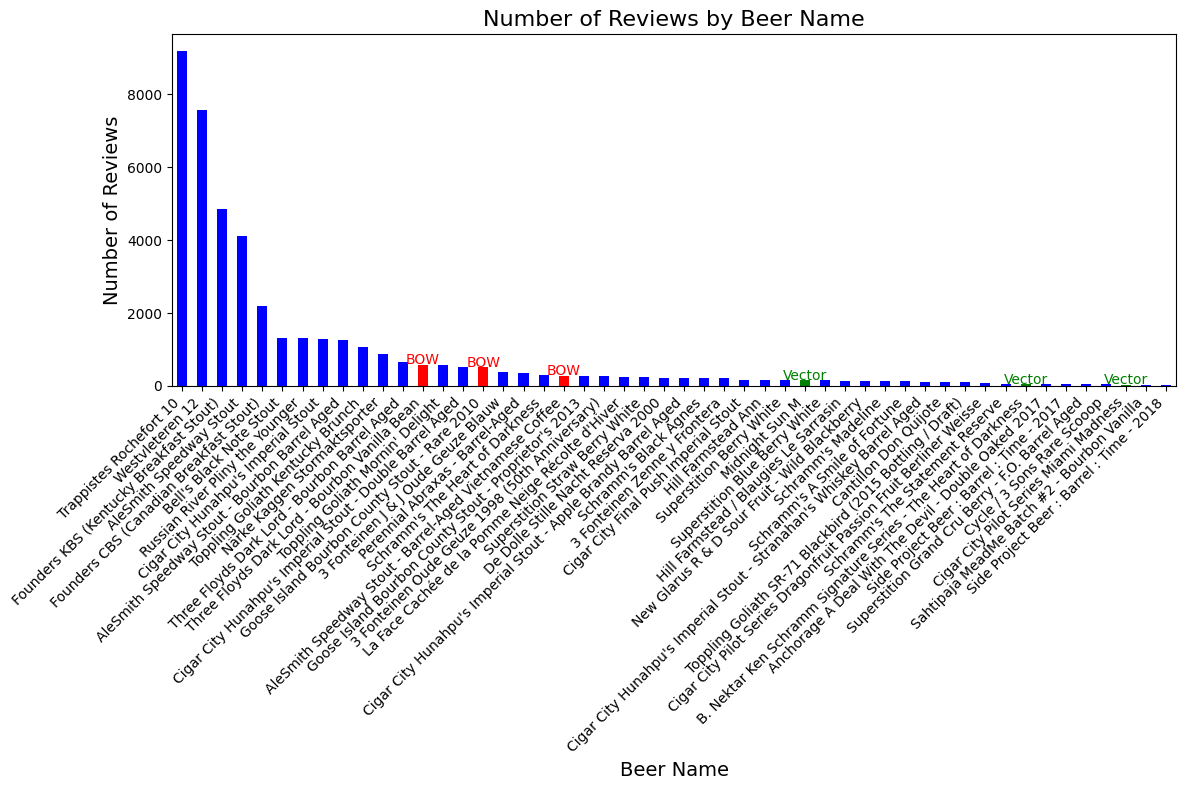

In [173]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Name' is the index
df_plot = df_processed.set_index('Name')

# Sort the 'Number of Reviews' column
df_plot['Number of Reviews'] = df_plot['Number of Reviews'].astype(int)
df_processed_sorted = df_plot['Number of Reviews'].sort_values(ascending=False)

# Normalize and strip the beer names to avoid whitespace or special character mismatches
df_processed_sorted.index = df_processed_sorted.index.str.strip()

# Plot the bar chart with increased figure size
plt.figure(figsize=(12, 8))  # Set a larger figure size

# Highlight the specific bars
highlight_bow = ['AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee',
                 'Goose Island Bourbon County Stout - Rare 2010',
                 'Three Floyds Dark Lord - Bourbon Vanilla Bean']

highlight_vector = ["Cigar City Pilot Series Miami Madness",
                    'B. Nektar Ken Schramm Signature Series - The Heart of Darkness',
                    'Midnight Sun M']

# Strip whitespaces from highlight lists too
highlight_bow = [name.strip() for name in highlight_bow]
highlight_vector = [name.strip() for name in highlight_vector]

# Create color mapping with normalized name matching
colors = ['red' if name in highlight_bow
          else 'green' if name in highlight_vector
          else 'blue' for name in df_processed_sorted.index]

# Plot with highlighted colors
bars = df_processed_sorted.plot(kind='bar', color=colors, legend=False)

# Add labels for the highlighted bars
for idx, label in enumerate(bars.get_xticklabels()):
    if label.get_text().strip() in highlight_bow:
        bars.text(idx, df_processed_sorted.iloc[idx] + 5, 'BOW', color='red', ha='center')
    elif label.get_text().strip() in highlight_vector:
        bars.text(idx, df_processed_sorted.iloc[idx] + 5, 'Vector', color='green', ha='center')

# Add title and labels
plt.title('Number of Reviews by Beer Name', fontsize=16)
plt.xlabel('Beer Name', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Top Recommendations:

- Bag of Words Approach: Based on this method, the top recommendation is AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee with a high evaluation score
  
- Word Vectors Approach: This method prioritizes long tail beers, with the top recommendation being B. Nektar Ken Schramm Signature Series - The Heart of Darkness with a high evaluation score

Top 3 Recommendations using Bag of Words: Based on this method, the beers with the highest relevance (similarity and sentiment) are:

1. AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee,
2. Goose Island Bourbon County Stout - Rare 2010,
3. Three Floyds Dark Lord - Bourbon Vanilla Bean.

Top 3 Recommendations using Word Vectors: The beers with the highest relevance here are:

1. B. Nektar Ken Schramm Signature Series - The Heart of Darkness,
2. Midnight Sun M
3. Cigar City Pilot Series Miami Madness

Insights:

Bag of Words:
- Recommends beers based purely on word overlap between the beer review and the customer’s preferences.
- More basic and direct, but could miss some beers that are described with semantically related words (but not exact matches).


Word Vectors (spaCy):
- Takes into account the contextual meaning of words in the reviews. Even if certain words in the beer description differ slightly from the customer’s preferences, the underlying semantic similarity will increase the evaluation score.
- As a result, beers like Cigar City Pilot Series Miami Madness and Midnight Sun M rank higher in recommendations based on their meaning-rich reviews, even if they don’t have the exact words as per customer’s preferences.

As seen in the graph, the Bag of Words (BoW) model tends to recommend more popular beers, which are clustered on the left side of the graph, which shows that these beers have received a significantly higher number of reviews. This suggests that BoW favors mainstream options with broader visibility. In contrast, the Word Vectors model captures more niche beers, positioned along the long tail of the distribution. This implies that Word Vectors are better at identifying beers with essential attributes, even if they have fewer reviews, making them stand out despite their lower popularity.

Word Vectors provide more refined and context-aware recommendations than Bag-of-Words.

If the customer’s preferences are described in a way that is semantically broad for example - they like beers with rich, creamy textures but those words don't appear exactly in the beer reviews. Word Vectors can offer better recommendations since they understand similar meanings.

Thus, when using Word Vectors like those from spaCy, your recommendations might shift to beers that better capture the essence of what the customer is looking for, even if the specific wording differs.




Comparison:

The output reveals a clear distinction between the recommendations generated using Bag of Words (BoW) versus Word Vectors. The evaluation scores from Word Vectors are lower (around 0.05) compared to the Bag of Words scores (ranging from 0.09 to 0.12). The beers recommended by Word Vectors show slightly more diversity in terms of types, while the Bag of Words recommendations lean towards well-known stout options. Though the Word Vectors may capture deeper semantic relationships between the review texts and product attributes, the differences in score magnitude suggest that BoW is performing similarly in terms of aligning reviews with ratings, albeit with marginally higher evaluation scores.


From the above graphs and tables:

The Bag of Words (BoW) model produced recommendations with relatively higher evaluation scores (0.09–0.12) compared to the Word Vectors model (0.05). However, despite the lower scores from Word Vectors, the latter provided more diverse and possibly more nuanced beer recommendations, as shown by the spread in the chart. This suggests that the Word Vectors model was able to capture deeper semantic relationships between the reviews and beer attributes, which may have led to more tailored results. Conversely, the BoW model, while effective, might have been limited in capturing such connections, resulting in slightly higher but less varied recommendations.

In [184]:
df_reset=sorted_df_word_vector.reset_index()
df_reset[df_reset[('Name','')]=='Toppling Goliath Kentucky Brunch'].index

Index([34], dtype='int64')

In [185]:
df_reset=sorted_df_bow.reset_index()
df_reset[df_reset[('Name','')]=='Toppling Goliath Kentucky Brunch'].index

Index([10], dtype='int64')

When comparing beer recommendations based on sentiment and similarity scores versus average ratings, it's clear that sentiment and similarity analysis provides a more tailored approach to aligning with user preferences. While the highest-rated beers, like **Toppling Goliath Kentucky Brunch**, enjoy popular appeal due to their ratings, they often lack specific desired attributes. Beers recommended through sentiment and similarity analysis—such as **AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee** and **B. Nektar Ken Schramm Signature Series - The Heart of Darkness**—not only receive high ratings but also resonate with user sentiment, suggesting they align more closely with consumer preferences. This method leads to recommendations that better address user needs, while relying solely on average ratings can overlook key aspects that enhance the overall experience.

Furthermore, the recommender model comparison highlights that **Bag of Words (BoW)** tends to favor more popular, frequently reviewed beers, while **Word Vectors** capture subtler attribute-based similarities. For example, Word Vectors rank **Toppling Goliath Kentucky Brunch** lower (35th), as it emphasizes specific beer attributes over popularity. Meanwhile, BoW ranks it higher (11th), favoring widely-reviewed, well-known options. This contrast shows that BoW tends to highlight more popular beers, whereas Word Vectors offer a more nuanced understanding of beer attributes.

# Task H

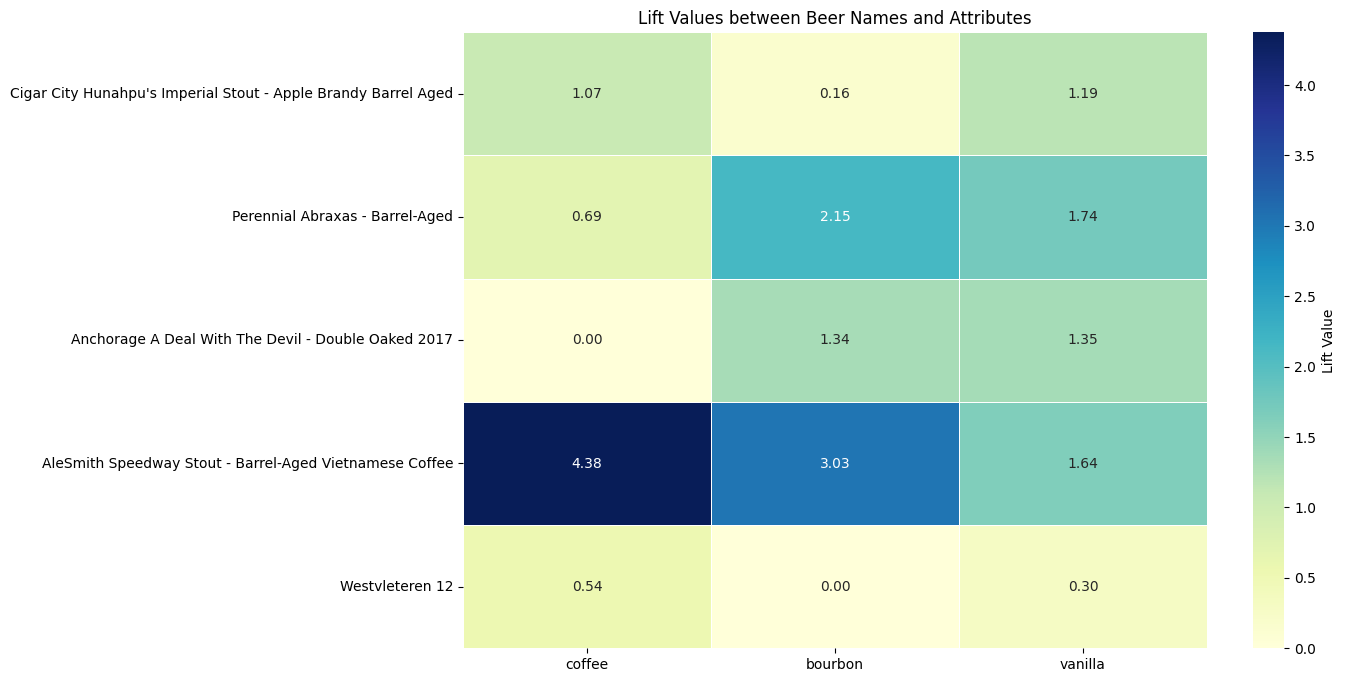

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample beers (5 random beer names from your DataFrame)
beers = df_group.sample(5)[('Name', '')].values


# Function to calculate the presence of attributes in each review
def attribute_presence(review, attributes):
    return [1 if attr in review else 0 for attr in attributes]

# Create a new column for each beer to track attribute presence
df['attribute_presence'] = df['processed_review'].apply(lambda review: attribute_presence(review, attributes))

# Initialize a matrix to store lift values
lift_matrix = pd.DataFrame(index=beers, columns=attributes)

# Calculate lift values for each beer and each attribute
for beer in beers:
    beer_reviews = df[df['Name'] == beer]  # Filter reviews for the specific beer
    total_reviews = beer_reviews.shape[0]  # Total number of reviews for the beer

    for attribute in attributes:
        # Count reviews containing the attribute for the beer
        beer_attr_count = beer_reviews['processed_review'].apply(lambda review: attribute in review).sum()

        # Count the total occurrences of the attribute across all reviews
        total_attr_count = df['processed_review'].apply(lambda review: attribute in review).sum()

        # Calculate lift: co-occurrence divided by the expected co-occurrence
        lift = (beer_attr_count / total_reviews) / (total_attr_count / df.shape[0]) if total_reviews > 0 and total_attr_count > 0 else 0

        # Store lift in the matrix
        lift_matrix.at[beer, attribute] = lift

# Convert lift matrix to numeric
lift_matrix = lift_matrix.apply(pd.to_numeric)


# Plot the lift matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(lift_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Lift Value'})
plt.title("Lift Values between Beer Names and Attributes")
plt.show()

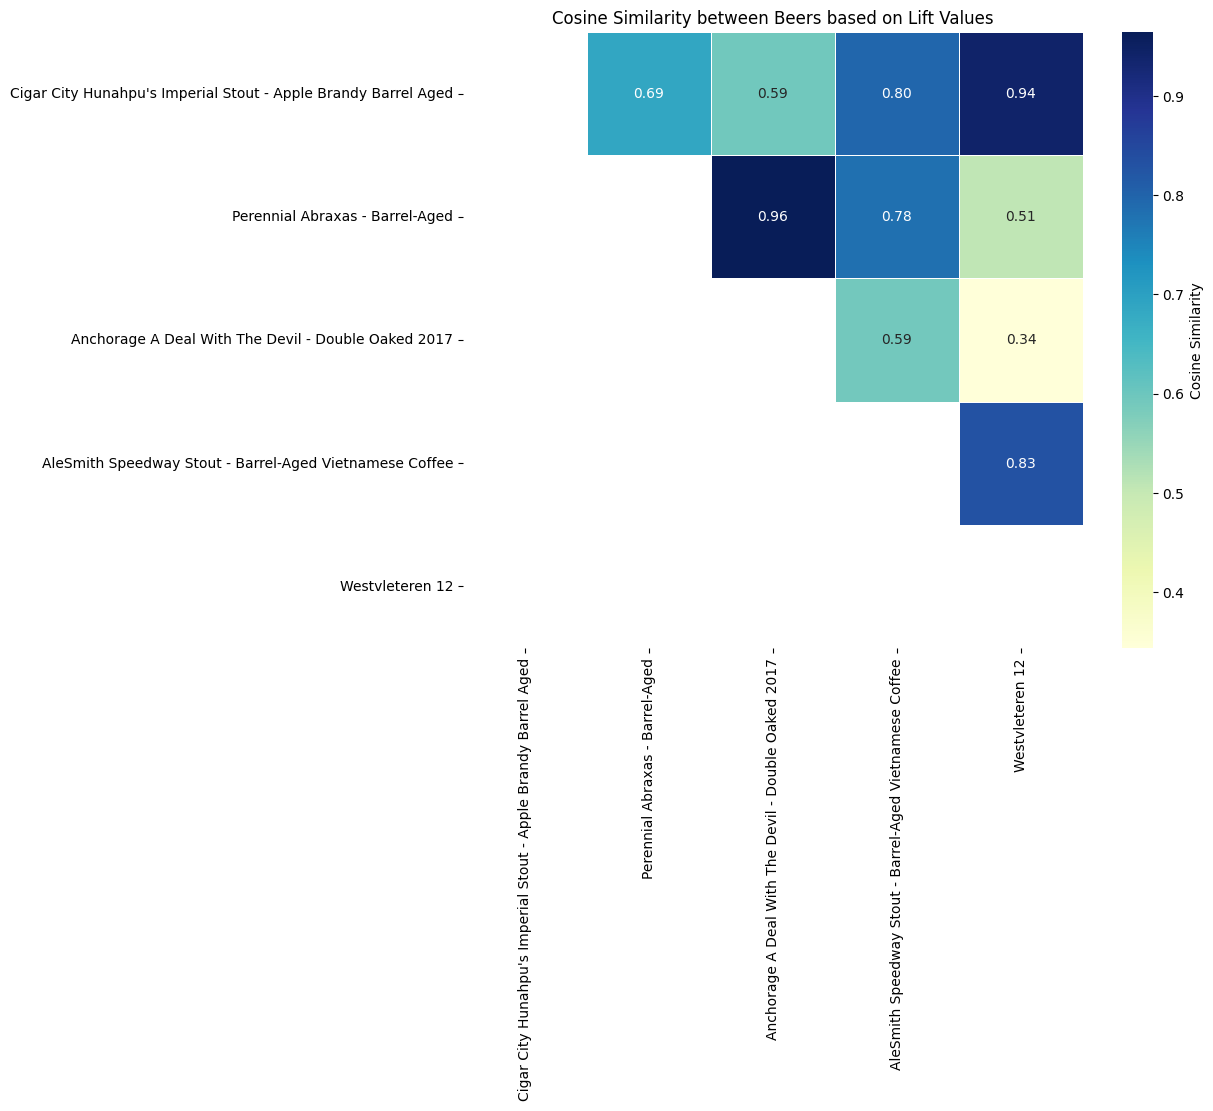

Highest similarity is between beers: ('Perennial Abraxas - Barrel-Aged', 'Anchorage A Deal With The Devil - Double Oaked 2017') with similarity score: 0.9644


In [187]:

# Define a function to calculate cosine similarity and return the upper triangular matrix
def calculate_cosine_similarity(lift_matrix):
    # Calculate cosine similarity between beer vectors
    similarity_matrix = cosine_similarity(lift_matrix)

    # Create a DataFrame for the similarity matrix
    similarity_df = pd.DataFrame(similarity_matrix, index=lift_matrix.index, columns=lift_matrix.index)

    # Set diagonal to NaN and get the upper triangular part
    similarity_df.values[np.tril_indices_from(similarity_df, k=0)] = np.nan

    return similarity_df


# Calculate the pairwise cosine similarity between beers
cosine_similarity_matrix = calculate_cosine_similarity(lift_matrix)



# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Cosine Similarity'})
plt.title("Cosine Similarity between Beers based on Lift Values")
plt.show()

# Find the beer combination with the highest similarity
max_similarity_value = cosine_similarity_matrix.max().max()  # Find the maximum similarity value
max_similarity_beers = cosine_similarity_matrix.stack().idxmax()  # Find the beer pair with the maximum similarity

print(f"Highest similarity is between beers: {max_similarity_beers} with similarity score: {max_similarity_value:.4f}")

In [188]:
# Display the cosine similarity matrix
cosine_similarity_matrix

,Cigar City Hunahpu's Imperial Stout - Apple Brandy Barrel Aged,Perennial Abraxas - Barrel-Aged,Anchorage A Deal With The Devil - Double Oaked 2017,AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee,Westvleteren 12
Cigar City Hunahpu's Imperial Stout - Apple Brandy Barrel Aged,NaN,0.686316,0.593387,0.795091,0.941201
Perennial Abraxas - Barrel-Aged,NaN,NaN,0.964370,0.780302,0.507261
Anchorage A Deal With The Devil - Double Oaked 2017,NaN,NaN,NaN,0.591922,0.343466
AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee,NaN,NaN,NaN,NaN,0.830050
Westvleteren 12,NaN,NaN,NaN,NaN,NaN


Finding the Most Similar Beer (Method and Logic):


Step-by-Step Explanation:
1. Selecting 5 Beers: From the list of 50 beers, we have selected 5 at random (This list will change if beers are resampled).

2. Using Lift Values as Similarity Metric: The logic to find the most similar beer involves calculating lift values between beer attributes and comparing them. The lift measures how often these attributes (coffee, vanilla, bourbon) co-occurs with a particular beer, compared to the expected occurrence.

- Higher lift values indicate a stronger association between the beer and the attribute.
- We can represent each beer as a vector of lift values for a set of attributes.


3. Cosine Similarity to Measure Similarity:

- The next step is to compute the cosine similarity between the vectors of two beers.
- Cosine similarity measures how similar two vectors are, with values ranging from 0 (completely different) to 1 (identical).


4. Finding the Most Similar Beer: After computing the cosine similarity between all pairs of beers, the matrix reveals which beers have the highest similarity score.

Example:
If choosing AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee as the beer of interest. The cosine similarity matrix (from the screenshot) shows how similar it is to the other 4 beers.

From above, we can see that the cosine similarity between AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee and Westvleteren 12 is 0.83, which is the highest similarity score for our beer of interest.

Thus, based on the cosine similarity of their lift values, the beer most similar to AleSmith Speedway Stout - Barrel-Aged Vietnamese Coffee is Westvleteren 12.